In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import seaborn as sns
import numpy as np

from sklearn.externals.joblib import Memory
memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

%matplotlib inline
plt.style.use('ggplot')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime
%reload_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


In [2]:
#cohort import

os.chdir('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling') #use to change working directory
wd= os.getcwd() #'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling'


final_pt_df2 = pd.read_csv(Path(wd + '/data/raw/csv/01102018_final_pt_df2_v.csv') , index_col=0) #only for patients with minimum vitals
patients= list(final_pt_df2['subject_id'].unique())
hadm_id= list(final_pt_df2['hadm_id'].unique())
icustay_id= list(final_pt_df2['icustay_id'].unique())
icustay_id= [int(x) for x in icustay_id]

time: 121 ms


In [100]:
#adding this in fow now, will eventually want to switch this to the 03-clinical_variables_final
import psycopg2
import getpass
conn = psycopg2.connect(dbname="mimic", user="student", host="luolabwkstn01.fsm.northwestern.edu", port="5432",
                        password=getpass.getpass(prompt='Password:'.format()))
cur=conn.cursor()

query_schema = 'SET search_path to ' + "mimiciii" + ';'

Password: ·····


time: 2.3 s


In [50]:
#reading in all of my data that is not limited to 72 hour time window between t_0 and t+72
date= '27082018' 

ventcategory_df=pd.read_csv(Path(
    wd+'/data/raw/csv/%s_ventcategory_df.csv' %(date)), index_col=0)

vaso_dose_72=pd.read_csv(Path(
    wd+'/data/raw/csv/72_hr_window/%s_vaso_dose_72.csv' %(date)), index_col=0)


echodata_72=pd.read_csv(Path(
    wd+'/data/raw/csv/72_hr_window/%s_echodata_72.csv' %(date)), index_col=0)
labs_all_nosummary_72=pd.read_csv(Path(
    wd+'/data/raw/csv/72_hr_window/%s_labs_all_nosummary_72.csv' %(date)), index_col=0)


weightfirstday_df=pd.read_csv(Path(
    wd+'/data/raw/csv/72_hr_window/%s_weightfirstday_df.csv' %(date)), index_col=0)
heightfirstday_df=pd.read_csv(Path(
    wd+'/data/raw/csv/72_hr_window/%s_heightfirstday_df.csv' %(date)), index_col=0)

vitals_all_nosummary_72=pd.read_csv(Path(
    wd+'/data/raw/csv/72_hr_window/%s_vitals_all_nosummary_72.csv' %(date)), index_col=0)
uti_all_72=pd.read_csv(Path(
    wd+'/data/raw/csv/72_hr_window/%s_uti_all_72.csv' %(date)), index_col=0)
bg_all_nosummary_72=pd.read_csv(Path(
    wd+'/data/raw/csv/72_hr_window/%s_bg_all_nosummary_72.csv' %(date)), index_col=0)

rrt_merged_allpt_df=pd.read_csv(Path(
    wd+'/data/raw/csv/72_hr_window/%s_rrt_merged_allpt_df.csv' %(date)), index_col=0)
gcs72_df=pd.read_csv(Path(
    wd+'/data/raw/csv/72_hr_window/%s_gcs72_df.csv' %(date)), index_col=0)

sofa_df_72=pd.read_csv(Path(
    wd+'/data/raw/csv/%s_sofa_df_72.csv' %(date)), index_col=0)

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


time: 14.3 s


In [4]:
def df_subset(df):
    try:
        df = df.loc[df.loc[:,'icustay_id'].isin(icustay_id),:]
    except KeyError or NameError:
        try:
            df = df.loc[df.loc[:,'hadm_id'].isin(hadm_id),:]
        except KeyError or NameError:
            df = df.loc[df.loc[:,'subject_id'].isin(patients),:]
    return(df)

time: 4.67 ms


In [51]:
# subsetting each dataframe to only patients in final_patients_df2_v:
dataframe_list= [
    ventcategory_df, vaso_dose_72, echodata_72,
    labs_all_nosummary_72, weightfirstday_df,
    heightfirstday_df, vitals_all_nosummary_72,
    uti_all_72, bg_all_nosummary_72,
    rrt_merged_allpt_df, gcs72_df, sofa_df_72
]

(
ventcategory_df, vaso_dose_72, echodata_72,
labs_all_nosummary_72, weightfirstday_df,
heightfirstday_df, vitals_all_nosummary_72,
uti_all_72, bg_all_nosummary_72,
rrt_merged_allpt_df, gcs72_df, sofa_df_72
) = (df_subset(df) for df in dataframe_list)

time: 1.02 s


#### all dataframes to melt together
- vaso_dose_72 : 
- ventcategory_df : 
- echodata_72 : 
- labs_all_nosummary_72 : 
- weightfirstday_df : 
- heightfirstday_df : 
- vitals_all_nosummary_72 :
- uti_all_72 :
- bg_all_nosummary_72 :
- rrt_merged_allpt_df :
- gcs72_df : 
- sofa_df_72: 

10/5/18
# Standardizing Columns in df to merge together
### list of columns in master df:
- subject_id
- hadm_id
- icustay_id
- charttime: starttime/charttime.
- endtime: going to be null for any value listed with only a charttime. 
- label
- value
- units?
- t_0
- delta
- days
- frequency
- dtype

### Vaso_dose

In [81]:
#vaso_dose_72.head()
vaso_dose_72= vaso_dose_72.rename(
    columns={'starttime':'charttime','label':'vaso_type'}
        )#.drop(labels='endtime', axis=1) 
#renaming starttime to charttime and dropping endtime

vaso_dose_72['uom']= 'mg'

time: 20.6 ms


In [82]:
list(vaso_dose_72)
vaso_dose_72.head()

#problem: There are 6 different vaso dilators, each with a vaso_rate and vaso_amount. what is diff between vaso_rate and vaso_amount? 
# if i only need 1 of the 2 values, then i just choose that and update label to be vaso_rate/amount. if i need both, then i need to
# make a new type label for vaso_rate and vaso_amount each vasodilator. 


#from the sql documentation:
# vaso_amount for carevue is not accurate

,icustay_id,charttime,endtime,vaso_rate,vaso_amount,vaso_type,t_0,delta,uom
4,200349.0,2139-06-02 16:31:00,2139-06-02 18:10:00,0.012030,0.073958,epinephrine,2139-06-02,0 days 16:31:00.000000000,mg
108,200952.0,2139-09-23 15:07:00,2139-09-24 06:43:00,0.020004,1.049601,epinephrine,2139-09-23,0 days 15:07:00.000000000,mg
109,200952.0,2139-09-25 12:00:00,2139-09-25 21:59:00,0.080068,1.962759,epinephrine,2139-09-23,2 days 12:00:00.000000000,mg
110,200952.0,2139-09-25 21:59:00,2139-09-26 07:38:00,0.060601,2.000000,epinephrine,2139-09-23,2 days 21:59:00.000000000,mg
122,200952.0,2139-09-23 23:12:00,2139-09-24 21:54:00,0.149992,7.990853,norepinephrine,2139-09-23,0 days 23:12:00.000000000,mg


time: 14.1 ms


In [10]:
vaso_dose_72.loc[vaso_dose_72.loc[:,'vaso_type']=='epinephrine','vaso_rate']

4        0.012030
108      0.020004
109      0.080068
110      0.060601
140      0.020000
141      0.015000
142      0.010000
143      0.005000
306      0.040021
386      0.140292
472      0.100000
528      0.030006
540      0.020000
541      0.010000
554      0.010000
555      0.010000
556      0.005000
557      0.002000
618      0.060232
660      0.050020
663      0.050000
664      0.050000
665      0.050000
865      0.030000
866      0.030017
931      0.020000
934      0.080212
937      0.030000
938      0.020000
939      0.010000
           ...   
16876    0.160000
16962    0.060102
16963    0.019868
17055    0.020010
17058    0.020002
17063    0.020000
17064    0.010000
17069    0.400000
17070    0.040000
17071    0.060000
17072    0.050000
17073    0.040000
17074    0.050000
17075    0.060000
17141    0.020010
17211    0.010000
17212    0.020000
17213    0.010000
17214    0.020000
17215    0.010000
17323    0.100000
17324    0.100000
17325    0.090000
17326    0.100000
17327    0

time: 18.2 ms


In [20]:
len(vaso_dose_72)

49722

time: 2.26 ms


In [25]:
print(len(vaso_dose_72.loc[vaso_dose_72.loc[:,'vaso_amount'].isna(),:]))
vaso_dose_72.loc[vaso_dose_72.loc[:,'vaso_amount'].isna(),:].head() #12712/49722 have vaso amount as NaN.

12712


,icustay_id,charttime,vaso_rate,vaso_amount,vaso_type,t_0,delta
144,201005.0,2169-10-25 07:30:00,0.10,NaN,norepinephrine,2169-10-25,0 days 07:30:00.000000000
145,201005.0,2169-10-25 07:50:00,0.05,NaN,norepinephrine,2169-10-25,0 days 07:50:00.000000000
148,201005.0,2169-10-25 09:30:00,0.10,NaN,norepinephrine,2169-10-25,0 days 09:30:00.000000000
152,201005.0,2169-10-25 13:30:00,0.50,NaN,norepinephrine,2169-10-25,0 days 13:30:00.000000000
156,201005.0,2169-10-26 08:00:00,0.25,NaN,norepinephrine,2169-10-25,1 days 08:00:00.000000000


time: 17 ms


In [27]:
vaso_dose_72.loc[vaso_dose_72.loc[:,'vaso_amount'].isna(),'vaso_type'].value_counts() 

norepinephrine    5951
phenylephrine     4574
dopamine          1464
vasopressin        315
epinephrine        214
dobutamine         194
Name: vaso_type, dtype: int64

time: 7.15 ms


In [30]:
vaso_dose_72.loc[:,'vaso_type'].value_counts()  

norepinephrine    24115
phenylephrine     16578
dopamine           5093
vasopressin        1810
epinephrine        1179
dobutamine          947
Name: vaso_type, dtype: int64

time: 11.3 ms


In [31]:
vaso_dose_72.loc[vaso_dose_72.loc[:,'vaso_amount'].isna(),'vaso_type'].value_counts()/ vaso_dose_72.loc[:,'vaso_type'].value_counts()
#it looks like the vaso_amounts missingness is roughly porportional to the total number. 
#ie not a large bias towards some vasodilators having more missing vaso_amount
#this looks like it could be a case for using just vaso_rate.

#also from the SQL documentation: vaso_amount for carevue is not accurate. 

norepinephrine    0.246776
phenylephrine     0.275908
dopamine          0.287453
vasopressin       0.174033
epinephrine       0.181510
dobutamine        0.204857
Name: vaso_type, dtype: float64

time: 18.6 ms


In [ ]:
#task 1: lets look at the vaso_rate distributions. 

In [36]:
vaso_dose_72.groupby('vaso_type')['vaso_rate'].describe()


,count,mean,std,min,25%,50%,75%,max
vaso_type,,,,,,,,
dobutamine,947.0,5.125060,4.055376,0.249004,2.500000,4.000000,6.300000,25.000000
dopamine,5093.0,7.355780,9.209863,0.244873,3.333333,5.250000,10.000000,523.784242
epinephrine,1179.0,0.092613,0.573252,0.002000,0.020000,0.036613,0.085357,19.244444
norepinephrine,24115.0,0.173934,0.609784,0.000113,0.050000,0.100000,0.203860,61.439027
phenylephrine,16578.0,1.650212,4.261559,0.010000,0.500000,1.000000,2.000000,420.168221
vasopressin,1810.0,1.806855,10.219186,0.000267,0.040000,2.000000,2.400000,428.571426


time: 80.3 ms


each of the vaso_dilators have a very large maximum value 
that is many standard deviations above the mean. I need to investigate this

In [53]:
#finding the outlier
dopa_outlier1= vaso_dose_72.loc[vaso_dose_72.loc[:,'vaso_rate']==523.7842421053,:] 
dopa_outlier1

,icustay_id,starttime,endtime,vaso_rate,vaso_amount,label,t_0,delta
69993,274503.0,2181-12-14 16:12:00,2181-12-14 22:02:00,523.784242,400.000315,dopamine,2181-12-13,1 days 16:12:00.000000000


time: 12 ms


In [46]:
#looking at all values from the outlier
vaso_dose_72.loc[vaso_dose_72.loc[:,'icustay_id']==274503.0,:] 

,icustay_id,charttime,vaso_rate,vaso_amount,vaso_type,t_0,delta
69986,274503.0,2181-12-14 16:12:00,0.986466,7.999642,norepinephrine,2181-12-13,1 days 16:12:00.000000000
69987,274503.0,2181-12-14 22:21:00,0.493142,1.827091,norepinephrine,2181-12-13,1 days 22:21:00.000000000
69989,274503.0,2181-12-13 10:02:00,9.967099,400.000027,dopamine,2181-12-13,0 days 10:02:00.000000000
69990,274503.0,2181-12-13 17:18:00,9.966993,393.120509,dopamine,2181-12-13,0 days 17:18:00.000000000
69991,274503.0,2181-12-14 01:50:00,7.980863,400.320080,dopamine,2181-12-13,1 days 01:50:00.000000000
69992,274503.0,2181-12-14 10:38:00,11.961724,161.451978,dopamine,2181-12-13,1 days 10:38:00.000000000
69993,274503.0,2181-12-14 16:12:00,523.784242,400.000315,dopamine,2181-12-13,1 days 16:12:00.000000000
69994,274503.0,2181-12-14 22:02:00,20.210527,88.320005,dopamine,2181-12-13,1 days 22:02:00.000000000
69995,274503.0,2181-12-14 22:48:00,20.208422,23.037601,dopamine,2181-12-13,1 days 22:48:00.000000000
69996,274503.0,2181-12-14 22:47:00,3.007519,3.714286,phenylephrine,2181-12-13,1 days 22:47:00.000000000


time: 13.8 ms


In [48]:
final_pt_df2.loc[final_pt_df2.loc[:,'icustay_id']==274503.0,:] 
#patient is a C_pos/A_full, makes sense why they may have had a high rate of vaso_rate

,subject_id,icustay_id,hadm_id,t_0_sc,t_end_sc,ab_course,t_0,t_end_consec,ICU_admit,dod_hosp,dod_ssn,dod_delta,org_list,spec_type_list,sc_result,final_bin
3692,49613,274503.0,120323,2181-12-12 00:00:00,2181-12-15 00:00:00,full,2181-12-13,2181-12-15,2181-12-12 18:40:21,NaN,NaN,NaN,GRAM POSITIVE BACTERIA,URINE,positive,C_pos/A_full


time: 16.5 ms


[Text(0,0,'epinephrine'),
 Text(0,0,'norepinephrine'),
 Text(0,0,'vasopressin'),
 Text(0,0,'phenylephrine'),
 Text(0,0,'dopamine'),
 Text(0,0,'dobutamine')]

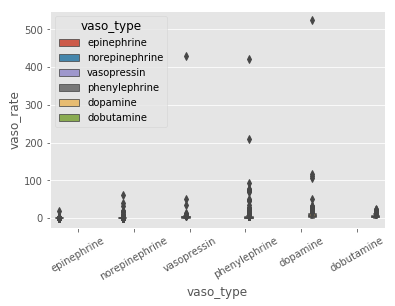

time: 349 ms


In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
g= sns.boxplot(x="vaso_type", y="vaso_rate", hue="vaso_type", data=vaso_dose_72)
g.set_xticklabels(g.get_xticklabels(), rotation=30)


In [ ]:
#vaso_dose_72.head()
vaso_dose_72= vaso_dose_72.rename(
    columns={'starttime':'charttime','label':'vaso_type'}
        )#.drop(labels='endtime', axis=1) 
#renaming starttime to charttime and dropping endtime

vaso_dose_72['uom']= 'mg'

## formatting the vaso_dose df to meet the master df standard:

In [89]:
for element in list(vaso_dose_72['vaso_type'].unique()):
    vaso_dose_72.loc[vaso_dose_72.loc[:,'vaso_type']==str(element),'vaso_type']= '%s_rate'%(element)
    
vaso_dose_72= vaso_dose_72.rename(
    columns={'vaso_type':'label','vaso_rate':'value'}).drop(labels='vaso_amount', axis=1)

AttributeError: 'dict' object has no attribute 'drop'

time: 74.6 ms


In [96]:
vaso_dose_72.head()

,icustay_id,charttime,endtime,value,label,t_0,delta,uom
4,200349.0,2139-06-02 16:31:00,2139-06-02 18:10:00,0.012030,epinephrine_rate_rate,2139-06-02,0 days 16:31:00.000000000,mg
108,200952.0,2139-09-23 15:07:00,2139-09-24 06:43:00,0.020004,epinephrine_rate_rate,2139-09-23,0 days 15:07:00.000000000,mg
109,200952.0,2139-09-25 12:00:00,2139-09-25 21:59:00,0.080068,epinephrine_rate_rate,2139-09-23,2 days 12:00:00.000000000,mg
110,200952.0,2139-09-25 21:59:00,2139-09-26 07:38:00,0.060601,epinephrine_rate_rate,2139-09-23,2 days 21:59:00.000000000,mg
122,200952.0,2139-09-23 23:12:00,2139-09-24 21:54:00,0.149992,norepinephrine_rate_rate,2139-09-23,0 days 23:12:00.000000000,mg


time: 12.1 ms


##### tinkering around with multi-index, maybe this can help?

In [84]:
# test1= vaso_dose_72.set_index(['vaso_type','icustay_id'])
# test2= vaso_dose_72.set_index(['vaso_type','vaso_rate','vaso_amount'])
# test3= vaso_dose_72.set_index(['vaso_type'])

# #del(test)
# test1.head(2)
# test2.head()
# test3.head()

,icustay_id,charttime,vaso_rate,vaso_amount,t_0,delta
vaso_type,,,,,,
epinephrine,200349.0,2139-06-02 16:31:00,0.012030,0.073958,2139-06-02,0 days 16:31:00.000000000
epinephrine,200952.0,2139-09-23 15:07:00,0.020004,1.049601,2139-09-23,0 days 15:07:00.000000000
epinephrine,200952.0,2139-09-25 12:00:00,0.080068,1.962759,2139-09-23,2 days 12:00:00.000000000
epinephrine,200952.0,2139-09-25 21:59:00,0.060601,2.000000,2139-09-23,2 days 21:59:00.000000000
norepinephrine,200952.0,2139-09-23 23:12:00,0.149992,7.990853,2139-09-23,0 days 23:12:00.000000000


time: 56.4 ms


In [80]:
test1.index

MultiIndex(levels=[['dobutamine', 'dopamine', 'epinephrine', 'norepinephrine', 'phenylephrine', 'vasopressin'], [200030.0, 200033.0, 200059.0, 200065.0, 200078.0, 200095.0, 200102.0, 200116.0, 200136.0, 200140.0, 200141.0, 200143.0, 200199.0, 200231.0, 200269.0, 200282.0, 200294.0, 200342.0, 200345.0, 200349.0, 200375.0, 200391.0, 200438.0, 200441.0, 200454.0, 200457.0, 200474.0, 200475.0, 200489.0, 200504.0, 200586.0, 200636.0, 200639.0, 200758.0, 200805.0, 200863.0, 200891.0, 200897.0, 200918.0, 200938.0, 200952.0, 200983.0, 200985.0, 201005.0, 201039.0, 201046.0, 201062.0, 201074.0, 201076.0, 201094.0, 201098.0, 201116.0, 201121.0, 201186.0, 201197.0, 201201.0, 201220.0, 201286.0, 201291.0, 201299.0, 201318.0, 201329.0, 201357.0, 201358.0, 201360.0, 201361.0, 201387.0, 201404.0, 201420.0, 201427.0, 201483.0, 201555.0, 201559.0, 201593.0, 201596.0, 201608.0, 201641.0, 201652.0, 201659.0, 201667.0, 201671.0, 201695.0, 201696.0, 201718.0, 201738.0, 201748.0, 201776.0, 201791.0, 201820.

time: 502 ms


In [60]:
# pd.melt(test1, col_level=0, id_vars=['charttime','delta','t_0'], var_name='label').head()
# ###hmm how does melt deal with multiindex

,charttime,delta,t_0,label,value
0,2139-06-02 16:31:00,0 days 16:31:00.000000000,2139-06-02,vaso_rate,0.012030
1,2139-09-23 15:07:00,0 days 15:07:00.000000000,2139-09-23,vaso_rate,0.020004
2,2139-09-25 12:00:00,2 days 12:00:00.000000000,2139-09-23,vaso_rate,0.080068
3,2139-09-25 21:59:00,2 days 21:59:00.000000000,2139-09-23,vaso_rate,0.060601
4,2139-09-23 23:12:00,0 days 23:12:00.000000000,2139-09-23,vaso_rate,0.149992


time: 27.4 ms


In [69]:
# #pd.melt(test1, col_level=1, id_vars=[('vaso_type','icustay_id'),'charttime','delta','t_0'], var_name='label')
# pd.melt(test1, id_vars=[('vaso_type','icustay_id')], var_name='label')


KeyError: ('vaso_type', 'icustay_id')

time: 52.5 ms


In [ ]:
# problem: i need to make a vaso_rate and vaso_amount for each vaso_type

In [44]:
# vaso_dose_72['vaso_type'].unique()

array(['epinephrine', 'norepinephrine', 'vasopressin', 'phenylephrine',
       'dopamine', 'dobutamine'], dtype=object)

time: 4.25 ms


# labs_all_nosummary_72
- subject_id
- hadm_id
- icustay_id
- charttime: starttime/charttime.
- endtime: going to be null for any value listed with only a charttime. 
- label
- value
- units?
- t_0
- delta
- days
- frequency
- dtype

In [97]:
#labs_all_nosummary_72
labs_all_nosummary_72.head()

,subject_id,hadm_id,icustay_id,charttime,label,valuenum,t_0,delta
0,9,150750,220597,2149-11-14 07:47:00,SODIUM,137.0,2149-11-13,1 days 07:47:00.000000000
81,9,150750,220597,2149-11-13 03:20:00,ALBUMIN,3.0,2149-11-13,0 days 03:20:00.000000000
82,9,150750,220597,2149-11-13 03:20:00,ANION GAP,13.0,2149-11-13,0 days 03:20:00.000000000
83,9,150750,220597,2149-11-13 03:20:00,BICARBONATE,22.0,2149-11-13,0 days 03:20:00.000000000
84,9,150750,220597,2149-11-13 03:20:00,CHLORIDE,99.0,2149-11-13,0 days 03:20:00.000000000


time: 19.8 ms


#### adding in UOM into labs

In [107]:
#importing unit of mesurements:
def uom_sql_import(file_path):
    if isinstance(file_path, str)== True:
        f = open(Path(file_path), 'r')
    else:
        f = open(Path(str(file_path)), 'r')

    SQL = open(file_path,'r').read()
    SQL_df= pd.read_sql_query(SQL,conn)   
    return(SQL_df)

time: 4.95 ms


In [129]:
lab_uom= uom_sql_import(Path(wd+'/data/raw/clinical_var_sql/unit_of_mesurement/labs_uom.sql'))


time: 22.2 s


In [130]:
lab_uom

,uom,label
0,g/dL,ALBUMIN
1,mEq/L,ANION GAP
2,%,BANDS
3,mEq/L,BICARBONATE
4,mg/dL,BILIRUBIN
5,mg/dL,BUN
6,mEq/L,CHLORIDE
7,mg/dL,CREATININE
8,mg/dL,GLUCOSE
9,%,HEMATOCRIT


time: 7.97 ms


In [124]:
labs_all_nosummary_72 = pd.merge(labs_all_nosummary_72, lab_uom, left_on='label', right_on='label')

time: 365 ms


In [131]:
del(lab_uom)

time: 704 µs


In [137]:
labs_all_nosummary_72.head()

,subject_id,hadm_id,icustay_id,charttime,label,value,t_0,delta,uom,endtime
0,9,150750,220597,2149-11-14 07:47:00,SODIUM,137.0,2149-11-13,1 days 07:47:00.000000000,mEq/L,NaN
1,9,150750,220597,2149-11-13 03:20:00,SODIUM,130.0,2149-11-13,0 days 03:20:00.000000000,mEq/L,NaN
2,9,150750,220597,2149-11-13 16:04:00,SODIUM,129.0,2149-11-13,0 days 16:04:00.000000000,mEq/L,NaN
3,9,150750,220597,2149-11-13 19:30:00,SODIUM,131.0,2149-11-13,0 days 19:30:00.000000000,mEq/L,NaN
4,9,150750,220597,2149-11-14 01:48:00,SODIUM,133.0,2149-11-13,1 days 01:48:00.000000000,mEq/L,NaN


time: 13.1 ms


## formatting the labs_all_nosummary_72 df to meet the master df standard:


In [134]:
labs_all_nosummary_72['endtime']= np.nan #adding in null endtimes

time: 6.85 ms


In [136]:
labs_all_nosummary_72= labs_all_nosummary_72.rename(
    columns={'valuenum':'value'}) #changing valuenum to value

time: 516 ms


In [ ]:
#missing days, may or may not keep this

In [139]:
labs_all_nosummary_72.head()

,subject_id,hadm_id,icustay_id,charttime,label,value,t_0,delta,uom,endtime
0,9,150750,220597,2149-11-14 07:47:00,SODIUM,137.0,2149-11-13,1 days 07:47:00.000000000,mEq/L,NaN
1,9,150750,220597,2149-11-13 03:20:00,SODIUM,130.0,2149-11-13,0 days 03:20:00.000000000,mEq/L,NaN
2,9,150750,220597,2149-11-13 16:04:00,SODIUM,129.0,2149-11-13,0 days 16:04:00.000000000,mEq/L,NaN
3,9,150750,220597,2149-11-13 19:30:00,SODIUM,131.0,2149-11-13,0 days 19:30:00.000000000,mEq/L,NaN
4,9,150750,220597,2149-11-14 01:48:00,SODIUM,133.0,2149-11-13,1 days 01:48:00.000000000,mEq/L,NaN


time: 21.1 ms


# ventcategory_df_melt
- subject_id
- hadm_id
- icustay_id
- charttime: starttime/charttime.
- endtime: going to be null for any value listed with only a charttime. 
- label
- value
- units?
- t_0
- delta
- days
- frequency
- dtype

In [140]:
ventcategory_df_melt = pd.melt(ventcategory_df, id_vars=['icustay_id','t_0'], var_name='label')
ventcategory_df_melt.head()

,icustay_id,t_0,label,value
0,267059.0,2182-11-12,vent_day1,Mech
1,278729.0,2159-11-08,vent_day1,Oxygen
2,219670.0,2190-08-01,vent_day1,Oxygen
3,295185.0,2154-11-11,vent_day1,Oxygen
4,211472.0,2193-12-11,vent_day1,None


time: 23.2 ms


In [161]:
ventcategory_df_melt['uom']='category'
ventcategory_df_melt['frequency']= 'once_per_day'
ventcategory_df_melt['dtype']= 'factor'
ventcategory_df_melt['endtime']=np.NaN
ventcategory_df_melt['charttime']=np.NaN
ventcategory_df_melt['days']=np.NaN
ventcategory_df_melt.loc[ventcategory_df_melt.loc[:,'label']=='vent_day1','days']=1
ventcategory_df_melt.loc[ventcategory_df_melt.loc[:,'label']=='vent_day2','days']=2
ventcategory_df_melt.loc[ventcategory_df_melt.loc[:,'label']=='vent_day3','days']=3

time: 35.4 ms


In [162]:
#adding in charttime

ventcategory_df_melt.loc[ventcategory_df_melt.loc[:,'label']=='vent_day1','charttime']=(
    pd.to_datetime(
        ventcategory_df_melt.loc[ventcategory_df_melt.loc[:,'label']=='vent_day1','t_0'])
            +pd.Timedelta(days=1))

ventcategory_df_melt.loc[ventcategory_df_melt.loc[:,'label']=='vent_day2','charttime']=(
    pd.to_datetime(
        ventcategory_df_melt.loc[ventcategory_df_melt.loc[:,'label']=='vent_day2','t_0'])
            +pd.Timedelta(days=2))

ventcategory_df_melt.loc[ventcategory_df_melt.loc[:,'label']=='vent_day3','charttime']=(
    pd.to_datetime(
        ventcategory_df_melt.loc[ventcategory_df_melt.loc[:,'label']=='vent_day3','t_0'])
            +pd.Timedelta(days=3))

ventcategory_df_melt['charttime']= pd.to_datetime(ventcategory_df_melt['charttime'])

time: 113 ms


In [165]:
ventcategory_df_melt.head()

,icustay_id,t_0,label,value,uom,frequency,dtype,endtime,charttime,days
0,267059.0,2182-11-12,vent_day1,Mech,category,once_per_day,factor,NaN,2182-11-13,1.0
1,278729.0,2159-11-08,vent_day1,Oxygen,category,once_per_day,factor,NaN,2159-11-09,1.0
2,219670.0,2190-08-01,vent_day1,Oxygen,category,once_per_day,factor,NaN,2190-08-02,1.0
3,295185.0,2154-11-11,vent_day1,Oxygen,category,once_per_day,factor,NaN,2154-11-12,1.0
4,211472.0,2193-12-11,vent_day1,None,category,once_per_day,factor,NaN,2193-12-12,1.0


time: 13 ms


# weightfirstday_df_melt
- subject_id
- hadm_id
- icustay_id
- charttime: starttime/charttime.
- endtime: going to be null for any value listed with only a charttime. 
- label
- value
- units?
- t_0
- delta
- days
- frequency
- dtype

In [166]:
weightfirstday_df_melt= pd.melt(weightfirstday_df, id_vars='icustay_id', var_name='label')
weightfirstday_df_melt.head()

,icustay_id,label,value
0,200012,weight,51.2
1,200014,weight,62.0
2,200019,weight,65.0
3,200030,weight,113.6
4,200033,weight,74.0


time: 15 ms


In [167]:
weightfirstday_df_melt['uom']='category'
weightfirstday_df_melt['frequency']= 'once_per_stay'
weightfirstday_df_melt['dtype']= 'float'
weightfirstday_df_melt['endtime']=np.NaN
weightfirstday_df_melt['charttime']=np.NaN
weightfirstday_df_melt['days']=1.0
weightfirstday_df_melt['delta']= np.NaN


time: 12.5 ms


In [169]:
weightfirstday_df_melt= (
        pd.merge(weightfirstday_df_melt, 
         final_pt_df2[['icustay_id','hadm_id','t_0']], 
         left_on='icustay_id',
         right_on='icustay_id')
)

time: 58.4 ms


In [171]:
weightfirstday_df_melt.head()

,icustay_id,label,value,uom,frequency,dtype,endtime,charttime,days,delta,hadm_id,t_0
0,200012,weight,51.200000,category,once_per_stay,float,NaN,NaN,1.0,NaN,177527,2153-12-23
1,200012,weight_admit,51.200001,category,once_per_stay,float,NaN,NaN,1.0,NaN,177527,2153-12-23
2,200012,weight_daily,51.200001,category,once_per_stay,float,NaN,NaN,1.0,NaN,177527,2153-12-23
3,200012,weight_echoinhosp,NaN,category,once_per_stay,float,NaN,NaN,1.0,NaN,177527,2153-12-23
4,200012,weight_echoprehosp,NaN,category,once_per_stay,float,NaN,NaN,1.0,NaN,177527,2153-12-23


time: 14.7 ms


# heightfirstday_df_melt
- subject_id
- hadm_id
- icustay_id
- charttime: starttime/charttime.
- endtime: going to be null for any value listed with only a charttime. 
- label
- value
- units?
- t_0
- delta
- days
- frequency
- dtype

In [ ]:
heightfirstday_df_melt= pd.melt(heightfirstday_df, id_vars='icustay_id', var_name='label')
heightfirstday_df_melt.head()

# vitals_all_nosummary_nonull
- subject_id
- hadm_id
- icustay_id
- charttime: starttime/charttime.
- endtime: going to be null for any value listed with only a charttime. 
- label
- value
- units?
- t_0
- delta
- days
- frequency
- dtype

In [ ]:
vitals_all_nosummary_nonull= vitals_all_nosummary_72.loc[vitals_all_nosummary_72['vitalid'].notnull(),:]#.count() #6930 NULL values
vitals_all_nosummary_nonull.head()

# uti_all_72_melt_notnull
- subject_id
- hadm_id
- icustay_id
- charttime: starttime/charttime.
- endtime: going to be null for any value listed with only a charttime. 
- label
- value
- units?
- t_0
- delta
- days
- frequency
- dtype

In [ ]:
uti_all_72_melt= pd.melt(
    uti_all_72[['hadm_id','charttime','value','valuenum','valueuom','label','fluid']],
    id_vars=['hadm_id','charttime'], var_name='label')

uti_all_72_melt_notnull= uti_all_72_melt[uti_all_72_melt['value'].notnull()] #1320954

uti_all_72_melt_notnull= uti_all_72_melt_notnull.drop_duplicates(subset=['hadm_id','label','charttime']) #drops the duplicated rows
#n=7796 rows

# bg_all_nosummary_72
- subject_id
- hadm_id
- icustay_id
- charttime: starttime/charttime.
- endtime: going to be null for any value listed with only a charttime. 
- label
- value
- units?
- t_0
- delta
- days
- frequency
- dtype

In [ ]:
#na values- removing all null values from value.
bg_all_nosummary_72= bg_all_nosummary_72.loc[bg_all_nosummary_72['value'].notnull(),:]
bg_all_nosummary_72.head()

# rrt_merged_allpt_df_notnull
- subject_id
- hadm_id
- icustay_id
- charttime: starttime/charttime.
- endtime: going to be null for any value listed with only a charttime. 
- label
- value
- units?
- t_0
- delta
- days
- frequency
- dtype

In [ ]:
#na values
rrt_merged_allpt_df_notnull = rrt_merged_allpt_df.loc[rrt_merged_allpt_df['rrt'].notnull(),:]
rrt_merged_allpt_df_notnull

# gcs72_df_melt_notnull
- subject_id
- hadm_id
- icustay_id
- charttime: starttime/charttime.
- endtime: going to be null for any value listed with only a charttime. 
- label
- value
- units?
- t_0
- delta
- days
- frequency
- dtype

In [ ]:
#need to reshape the dataframe
gcs72_df_melt = pd.melt(gcs72_df, id_vars=['subject_id','hadm_id','icustay_id','t_0','ICU_admit','admit_plus_day','delta'], var_name='label')

gcs72_df_melt_notnull= gcs72_df_melt[gcs72_df_melt['value'].notnull()] #62772 ->62650
gcs72_df_melt_notnull.head()

# sofa_df_melt_notnull
- subject_id
- hadm_id
- icustay_id
- charttime: starttime/charttime.
- endtime: going to be null for any value listed with only a charttime. 
- label
- value
- units?
- t_0
- delta
- days
- frequency
- dtype

In [ ]:
#need to reshape the dataframe
sofa_df_melt = pd.melt(sofa_df_72, id_vars=['subject_id','hadm_id','icustay_id','t_0','day','ICU_admit','approx_charttime','floor_charttime'], var_name='label')

sofa_df_melt_notnull= sofa_df_melt[sofa_df_melt['value'].notnull()] #606651 ->302459
sofa_df_melt_notnull.head()